In [1]:
import pandas as pd
from datasets import load_dataset, dataset_dict
import gzip
import bz2
import numpy as np
from tqdm import tqdm
import concurrent.futures
from sklearn.model_selection import train_test_split

/home/yvson/Documents/Faculdade/NLP/NLP-final-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("ag_news")

In [3]:
train , validation = train_test_split(dataset['train'].to_pandas(), test_size=0.065, random_state=42)

In [4]:
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    dataset = pd.DataFrame(dataset)
    dataset = dataset[['text', 'label']]
    dataset = dataset.groupby("label").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

In [5]:
Categories = ["World", "Sports", "Business", "Sci/Tech"]
Categories

['World', 'Sports', 'Business', 'Sci/Tech']

In [6]:
perc_train = 0.14
perc = 0.25

train_df = get_balanced_dataset(train, perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(validation, perc)

train_df['Categories'] = train_df['label'].apply(lambda x: Categories[x])

# Contagem de labels em cada dataset
count_train = train_df['label'].value_counts()
count_test = teste_df['label'].value_counts()
count_valid = valid_df['label'].value_counts()

# Encontrando a menor contagem em cada dataset
min_count_train = count_train.min()
min_count_test = count_test.min()
min_count_valid = count_valid.min()

# Fazendo o resample (downsampling) para o dataset de treino
train_df = pd.concat([
    train_df[train_df['label'] == label].sample(n=min_count_train, random_state=42)
    for label in train_df['label'].unique()
])

# Fazendo o resample (downsampling) para o dataset de teste
teste_df = pd.concat([
    teste_df[teste_df['label'] == label].sample(n=min_count_test, random_state=42)
    for label in teste_df['label'].unique()
])

# Fazendo o resample (downsampling) para o dataset de validação
valid_df = pd.concat([
    valid_df[valid_df['label'] == label].sample(n=min_count_valid, random_state=42)
    for label in valid_df['label'].unique()
])


training_set = list(zip(train_df["text"], train_df["label"]))
test_set = list(zip(teste_df["text"], teste_df["label"]))


<Axes: title={'center': 'Distribuição das categorias - Treino AGNews'}, xlabel='label'>

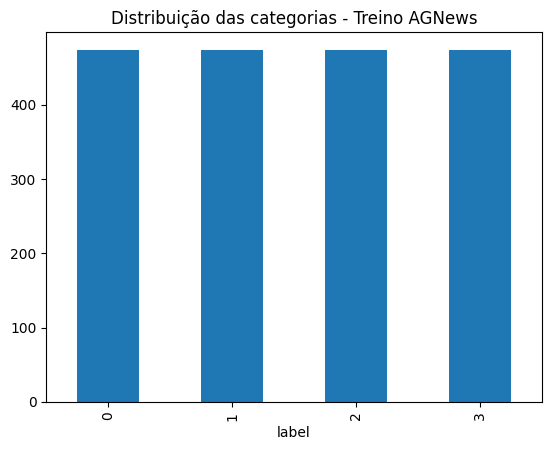

In [9]:
pd.DataFrame(valid_df)['label'].value_counts().plot(kind='bar', title='Distribuição das categorias - Treino AGNews')

In [31]:
train_df

,text,label,Categories
1593,Pakistan Turns Up No Signs of Bin Laden Pakist...,0,World
465,Kenya Anti-Graft Chief Resigns The chairman of...,0,World
1615,US jets hit Fallujah ahead of expected offensi...,0,World
490,Silent march in France on 100th day of captivi...,0,World
1926,Funeral held for anti-apartheid Afrikaner The ...,0,World
...,...,...,...
13023,Toshiba Third Party Memory Module Failure Tosh...,3,Sci/Tech
12251,Ex-Austin student indicted for data theft com ...,3,Sci/Tech
13954,Some Dell AC Adapters Recalled Although seven ...,3,Sci/Tech
13423,Microsoft checks out new IE security flaw repo...,3,Sci/Tech


In [32]:
valid_df

,text,label
0,Indian refinery blast injures 16 Sixteen worke...,0
1,Jailed uprising leader Barghouti will seek Pal...,0
2,Concern over N Korea missile test Japan will u...,0
3,Karzai maintains lead in early Afghan vote cou...,0
4,Agency 'slow tackling jam misery' Motorists su...,0
...,...,...
1945,INTERVIEW: Sony Ericsson Chief Sees Slower Gro...,3
1946,Dilithium has 80 of 3G video telephony test ma...,3
1947,Genetic Material May Help Make Nano-Devices: S...,3
1948,Google Phishing Holes Found (NewsFactor) NewsF...,3


In [33]:
teste_df

,text,label
375,US Airstrikes Said to Kill at Least 44 in Iraq...,0
422,Nepal Seeks Talks to End Rebel Blockade of Cap...,0
9,Vietnam Opens Bunker Used by Ho Chi Minh (AP) ...,0
73,"Sudan Govt rejects call to separate religion, ...",0
354,"Mauritania coup kingpin held Nouakchott, Mauri...",0
...,...,...
1531,Ask Jeeves revamps search engine Ask Jeeves In...,3
1695,Yahoo Doubles Free E-Mail Storage Limits Yahoo...,3
1773,"Microsoft settles antitrust cases with Novell,...",3
1860,Fixed-to-mobile substitution gaining momentum ...,3


In [34]:
training_set = list(zip(train_df["text"], train_df["label"]))
test_set = list(zip(teste_df["text"], teste_df["label"]))

In [35]:
def NDC_gzip(x1,x2):
    Cx1x2 = len(gzip.compress(" ".join([x1 , x2]).encode()))
    Cx1 = len(gzip.compress(x1.encode())) 
    Cx2 = len(gzip.compress(x2.encode()))

    return (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

def NDC_bz2(x1,x2):
    Cx1x2 = len(bz2.compress(" ".join([x1 , x2]).encode()))
    Cx1 = len(bz2.compress(x1.encode())) 
    Cx2 = len(bz2.compress(x2.encode()))

    return (Cx1x2 - min(Cx1, Cx2)) / max(Cx1, Cx2)

In [36]:
def split_list(data, n):
    k, m = divmod(len(data), n)
    return [data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

def cal_KNN_NDC(test_set):
    K = 3
    y_hat = []

    for (x1 , _) in tqdm(test_set):
        distances_to_xtest = []
        for (x2 , _) in training_set:
            distances_to_xtest.append(NDC_bz2(x1, x2))
        
        sorted_idx = np.argsort(distances_to_xtest)
        k_nearest = sorted_idx[:K]
        y_hat.append(training_set[max(set(k_nearest), key=k_nearest.tolist().count)][1])

    return y_hat


workers = 12

results = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    splited_data =  split_list(test_set, workers)
    processed = executor.map(cal_KNN_NDC, splited_data)

    for result in processed:
        results.append(result)

y_hat = [item for sublist in results for item in sublist]

100%|██████████| 158/158 [08:43<00:00,  3.31s/it]


In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_test = [y for (_, y) in test_set]

#compute accuracy
accuracy = sum([y_hat[i] == y_test[i] for i in range(len(y_test))]) / len(y_test)
print(f"Accuracy: {accuracy}")

#compute recall
recall = recall_score(y_test, y_hat, average='macro')
print(f"Recall: {recall}")

#compute precision
precision = precision_score(y_test, y_hat, average='macro')
print(f"Precision: {precision}")

#compute f1 score
f1 = f1_score(y_test, y_hat, average='macro')
print(f"F1 Score: {f1}")

Accuracy: 0.6584210526315789
Recall: 0.6584210526315789
Precision: 0.6612588142558085
F1 Score: 0.6582251046357999


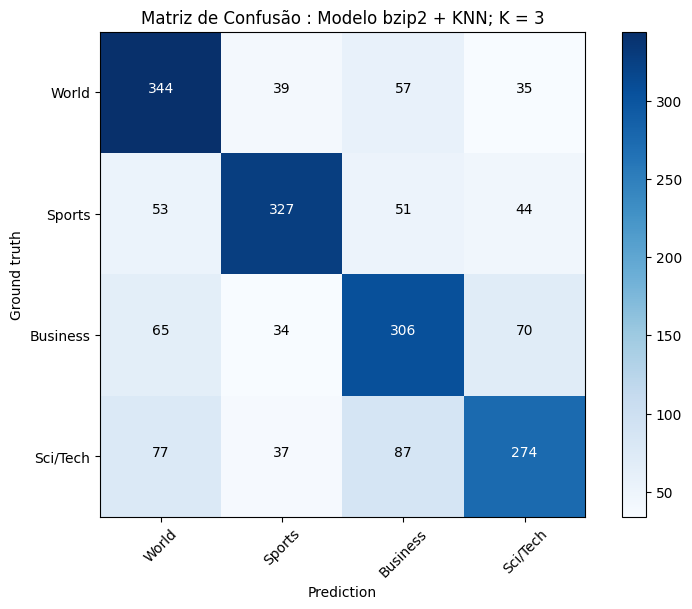

In [39]:
conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão : Modelo bzip2 + KNN; K = 3')
plt.colorbar()


tick_marks = np.arange(len(Categories))
plt.xticks(tick_marks, Categories, rotation=45)
plt.yticks(tick_marks, Categories)


thresh = conf_matrix.max() / 2.
for i, j in [(i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]:
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
plt.show()